# Introducción
En este documento vamos a expandir una serie de consultas utilizando dos modelos basados en word embeddings: Word2Vec$^{[1]}$ y Glove$^{[2]}$. Al principio, se explicará brevemente como funciona cada uno de estos modelos y sus respectivas librerías de Python. Posteriormente, se realizará una pequeña comparativa entre ambos modelos teniendo en cuenta la P@k obtenida en las consultas. Por último, se realizará también una comparativa de rendimiento de ambos modelos.

# Consideraciones previas
En este documento partimos con la colección de tweets ya indexada en ElasticSearch. Este paso se realizó utilizando el script _index.py_, que se encuentra disponible en la carpeta _src_ de la entrega. La colección usada es la colección por defecto con tweets del 4 de febrero de 2008 en inglés.

# Setup
Lo primero que vamos a hacer será importar las librerías que se usarán a lo largo de este trabajo. A medida que se vayan usando iremos detallando el funcionamiento de las más importantes.

In [1]:
import string
import sys

import elasticsearch.helpers
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from adjustText import adjust_text
from elasticsearch import Elasticsearch, helpers
from elasticsearch_dsl import Search, Q
from gensim.models import word2vec
from glove import Glove
from glove import Corpus
from memory_profiler import memory_usage
from sklearn.decomposition import PCA
from stop_words import get_stop_words

%load_ext memory_profiler
%matplotlib inline

sys.path.append('../src/')

También iniciaremos la conexión con ElasticSearch. Además, indicamos el nombre de la colección dónde se realizarán las consultas.

We will also initiate the connection with ElasticSearch. In addition, we indicate the name of the collection where the queries will be made.

In [2]:
client = Elasticsearch()
index = '2008-feb-02-04-en'

# Descripción de los modelos
Antes de usar cada modelo vamos a describir brevemente como funcionan. No entraremos en detalle en el funcionamiento interno de cada uno, pero si que aclararemos lo que hacen a grandes rasgos para que posteriormente cuando entrenemos cada modelo y veamos los resultados podamos entender lo que ocurre 'por detrás'.<br> Ambos modelos producen como resultado unos vectores que representan cada palabra de la colección. Además, estos vectores también representan las relaciones que hay entre varias palabras, por lo que realizando varias operaciones entre ellos podemos obtener como resultado palabras relacionadas a las originales.

## Word2Vec
Word2Vec utiliza una red neuronal para obtener los vectores de palabras a partir de una serie de documentos. Este modelo puede utilizar dos arquitecturas distintas para obtener los vectores:
- CBOW: En el caso de CBOW (**C**ontinuous **b**ag **o**f **w**ords), si tenemos como palabra objetivo 'super', la entrada que se utilizará para entrenar la red neuronal serán cada una de las palabras que rodean a la palabra 'super' en el documento. El número de palabras cercanas que se utilizan para entrenar la red neuronal es el 'contexto'. A partir de este contexto se modifican los pesos de la capa oculta de la red neuronal para obtener como resultado un vector que represente la palabra 'super'. Dicho de otra manera, al entrenar el modelo intentamos maximizar la probabilidad de que se obtenga como resultado la palabra 'super' dado el contexto.
- Skip-gram: En este caso, utilizando el mismo ejemplo que para el modelo CBOW, la entrada a la red neuronal sería 'super', y se modificarían los valores de la capa oculta para producir como resultado cada una de las palabras que se encuentran alrededor de 'super' (el contexto).


## GloVe
Según Jeffrey Penington, creador de Glove, el modelo de Word2Vec no es del todo óptimo ya que no explota al máximo las estadísticas de cada palabra$^{[3]}$.
En el caso de GloVe (**Glo**bal **Ve**ctors for word representation), se utiliza una matriz de co-ocurrencia que representa las estadísticas de cada palabra para obtener los resultados. Cada valor $M_{ij}$ de esta matriz representa con cuanta frecuencia aparece la palabra i en el contexto de la palabra j. Una vez que tenemos esta matriz podemos proceder a crear los vectores de palabras a partir de ella. Para obtener estos vectores se utiliza un modelo de regresión bastante sencillo$^{[4]}$, pero en el que no entraremos en detalle.

# Entrenamiento de los modelos
Lo primero que necesitamos hacer es entrenar ambos modelos. Para entrenarlos utilizaremos la colección de tweets completa. Dado que contamos con una cantidad de documentos relativamente grande (390000) y que es una buena práctica, vamos a crear una clase que vaya generando una lista con las palabras de cada tweet de la colección de manera perezosa. De esta forma, no tendremos que guardar todos los tweets de la colección en una lista en memoria RAM. 
Los modelos reciben un iterable como parámetro para poder entrenarlos. Lo único que tenemos que hacer es implementar la función predefinida de python \_\_iter\_\_ dentro de nuestra clase para que los objetos que creemos se comporten como un iterable cualquiera.

Además, cabe destacar que antes de devolver cada palabra en el generador realizamos un pequeño preprocesamiento para mejorar el rendimiento tanto de Word2Vec como de Glove. En primer lugar, tokenizaremos el tweet usando la librería nltk, que contiene un módulo$^{[5]}$ dedicado específicamente a tokenizar tweets. Además, también eliminaremos los signos de puntuación que deje el tokenizador sueltos. En el caso de que la palabra sea un enlace a una página externa entonces no eliminaremos los símbolos de puntuación. Por último, eliminaremos las palabras vacías de cada tweet. La lista de palabras vacías se obtuvo usando la librería externa _stop-words_ (a esta lista se le añadió la palabra 'Re' para eliminarla de los retweets).

In [3]:
class SentencesGenerator:
    def __init__(self, client, index):
        self.s = Search(using=client, index=index).query(Q())
        self.stop_words = get_stop_words('english')
        self.stop_words.append('Re')
    
    def __iter__(self):
        # creamos una tabla de traducción que usaremos para eliminar los simbolos de puntuación.
        remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
        for tweet in self.s.scan():
            # tokenizamos el tweet
            words = nltk.tokenize.casual.casual_tokenize(tweet.text)
            
            # eliminamos los simbolos de puntuacion sobrantes
            words = [word.translate(remove_punctuation_map) for word in words
                     if not word.startswith('http')]
            
            # eliminamos palabras vacias
            words = [word for word in words if word != '' and word not in self.stop_words]
            yield words


sentences_generator = SentencesGenerator(client, index)

## Entrenamiento de Word2Vec
La implementación de Word2Vec de gensim$^{[6]}$ hace que sea muy sencillo entrenar el modelo. Lo único que tendremos que tener en cuenta son los parámetros que le suministramos al constructor. A continuación se muestra una pequeña descripción de cada parámetro usado:
- El primer parámetro es el iterable mencionado anteriormente que va generando cada tweet con las palabras separadas.
- En segundo lugar, queremos que los vectores generados por word2vec tengan una dimension igual a 100.
- En el tercer parámetro indicamos que Word2Vec tenga en cuenta las 5 palabras próximas a la palabra dada a la hora de entrenar el modelo.
- El cuarto parámetro indica que sólo se añadan al vocabulario generado por word2vec aquellas palabras que aparezcan como mínimo 10 veces en la colección. De esta manera eliminaremos muchas palabras con errores ortográficos, links que se añaden a muchos tweets, o palabras que sólo tienen sentido entre pequeños grupos de personas y por consiguiente no aparecen muchas veces (por ejemplo, motes).
- Por último, indicamos que sólo se utilice un thread a la hora de entrenar el modelo. Esto se debe a que si utilizábamos más de 1 thread se observaban pequeñas variaciones en los vectores obtenidos cada vez que se ejecutaba el script. Con un thread nos aseguramos de obtener resultados deterministas cada vez que entrenemos el modelo.

También cabe destacar que el algoritmo utilizado es el CBOW (algoritmo por defecto).

In [4]:
w2v_model = word2vec.Word2Vec(sentences_generator, size=100, window=5, min_count=10, workers=1)

Ahora vamos a comprobar que el modelo se entrenó correctamente pidiéndole las palabras más similares a _football_:

In [5]:
w2v_model.wv.most_similar('football')

[('sports', 0.823975145816803),
 ('rugby', 0.7716653347015381),
 ('game', 0.766954779624939),
 ('commercials', 0.7591221332550049),
 ('soccer', 0.746818482875824),
 ('superbowl', 0.7457777261734009),
 ('halftime', 0.7408241629600525),
 ('fox', 0.7387694716453552),
 ('SB', 0.737731397151947),
 ('patriots', 0.7360270023345947)]

Como se puede ver, obtenemos una lista con 10 tuplas que contienen las palabras más similares a la palabra dada. Cada una de estas tuplas almacena la palabra y el nivel de similitud con la palabra original.

## Entrenando el modelo de Glove
En el caso de Glove la implementación oficial del modelo se encuentra implementada en C. Por lo tanto, teniendo en cuenta el alcance de este trabajo, vamos a utilizar una implementación no oficial$^{[7]}$ del modelo escrita en python por comodidad.<br>La forma de entrenar este modelo es un poco distinta a la utilizada con Word2Vec. En primer lugar utilizaremos la clase _Corpus_ para generar una matriz de co-ocurrencia a partir de un iterable de sentencias (se utilizará el mismo iterable que para Word2Vec). El parámetro _window_ que se le pasa al corpus tiene la misma utilidad que en Word2Vec (número de palabras próximas que se tienen en cuenta). Una vez hecho esto, generaremos los vectores de palabras a partir de la matriz de co-ocurrencia.

In [6]:
corpus = Corpus()
corpus.fit(sentences_generator, window=5)
glove_model = Glove(no_components=100, learning_rate=0.025)
glove_model.fit(corpus.matrix, epochs=20,
                no_threads=1, verbose=False)
glove_model.add_dictionary(corpus.dictionary)

Ahora comprobaremos que el modeo se entrenó correctamente, igual que con Word2Vec:

In [7]:
glove_model.most_similar('football', number=10)

[('game', 0.95212946795530085),
 ('basketball', 0.9475275771818038),
 ('movies', 0.93916337039753928),
 ('hockey', 0.91716317868730268),
 ('boring', 0.91544324840820512),
 ('tv', 0.90773804016306892),
 ('commercials', 0.90526278587033671),
 ('exciting', 0.8986016924748701),
 ('watching', 0.88793783392872594)]

Como podemos ver, una vez tenemos entrenados los modelos ambos se utilizan de manera casi idéntica.

# Dibujando vectores de palabras
Ahora que ya tenemos listos los modelos vamos a dibujar un gráfico que nos ayude a visualizar como funcionan estos modelos. Trabajaremos con el modelo de Word2vec, aunque estos pasos serían totalmente aplicables a Glove también. Primero vamos a comprobar que cada vector tiene 100 dimensiones, como indicamos en el constructor de Word2Vec:

In [8]:
len(w2v_model.wv['football'])

100

Las palabras que suelan aparecer en el mismo contexto tendrán unos vectores parecidos, mientras que las palabras que no tengan nada en común tenderán a estar alejadas. Para poder ver esta relación vamos a reducir la dimensionalidad de algunos vectores a 2 dimensiones utilizando la técnica de PCA (Principal Component Analysis):

In [9]:
words = ['American', 'Football', 'Conference', 'David', 'Tyree',
         'defensive', 'end', 'Eli', 'Manning', 'football',
         'Glendale', 'Laurence', 'Maroney', 'Miami', 'Dolphins',
         'Michael', 'Strahan', 'National', 'League', 'England',
         'Patriots', 'New', 'York', 'Giants', 'NFL', 'Plaxico',
         'Burress', 'quarterback', 'Randy', 'Moss', 'running',
         'back', 'Super', 'Bowl', 'Wide', 'receiver']

X_train = [w2v_model.wv[word] for word in w2v_model.wv.vocab]
X = [w2v_model.wv[word] for word in words]
pca = PCA(n_components=2)
pca.fit(X_train)
result = pca.transform(X)

Ahora que tenemos los vectores en 2 dimensiones, podemos realizar un scatter plot y dibujar cada palabra en el plano:

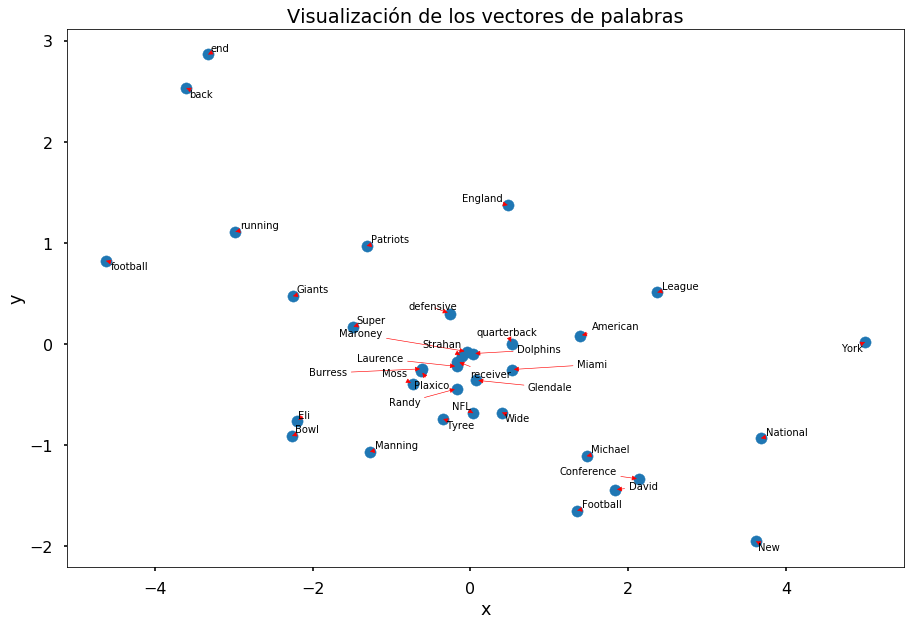

In [10]:
plt.style.use('seaborn-poster')

plt.title('Visualización de los vectores de palabras')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(result[:,0], result[:,1])

texts = []
for i, word in enumerate(words):
    texts.append(plt.text(result[i,0], result[i,1], word))

adjust_text(texts, force_text=0.55, arrowprops=dict(arrowstyle="-|>", color='r', lw=0.6))

plt.tight_layout()
plt.show()

# Expansión de consultas

Ahora vamos a pasar a expandir una serie de consultas sobre la colección de tweets. La idea principal será obtener un número k de términos similares por cada término de la consulta original. Para ello partiremos de una consulta q0:<br><br>
$$q_0 = t_1 + t_2 + t_3 + ... + t_n$$
<br>
A continuación obtenemos los términos similares para cada término de q0, y realizamos una consulta expandida qe de esta forma:<br><br>
$$q_e = t_1 + sim(t1) + t_2 + sim(t_2)\ +\ ...\ +\ t_n + sim(t_n)$$
<br>
Una vez que tengamos la consulta expandida tanto para el modelo de Word2Vec como para el de Glove seleccionaremos los 10 resultados de la consulta con más puntuación devuelta por ElasticSearch. Utilizando nuestro criterio, seleccionaremos cuáles de estos resultados nos parecen relevantes y cuáles no, e indicaremos si obtenemos algún beneficio o no comparándo estos resultados con los resultados de la consulta original. Por último, miraremos que tweet subió y bajó más de ranking al realizar las consultas expandidas con respecto a la consulta original.

Para evitar que el tamaño de la documentación sea muy grande, no incluimos el código fuente de las funciones que se usan en este apartado. Este código, junto con una breve descripción de cada función, se encuentra disponible en el archivo query_expansion.py de la carpeta src.

In [11]:
from query_expansion import *

## Super Bowl
Vamos a empezar con la consulta Super Bowl. Dado que es la primera consulta que expandimos explicaré brevemente los pasos seguidos para obtener cada resultado.

In [12]:
start_query = "Super Bowl"

### Resultados originales
En primer lugar obtenemos los resultados sin expandir la consulta (result_q0). En esta variable guardaremos los primeros 1000 resultados devueltos por ElasticSearch, mientras que en la tabla siguiente mostraremos los 10 primeros.

In [13]:
result_q0 = get_elasticsearch_result([['Super'], ['Bowl']], client, index)

| resultado | relevante | razón |
|:-----:|:----:|:---:|
|{{result_q0[0][0]}}   |Sí  |  |
|{{result_q0[1][0]}}   |Sí | |
|{{result_q0[2][0]}}   |Sí | |
|{{result_q0[3][0]}}   |No | |
|{{result_q0[4][0]}}   |No | Repetido |
|{{result_q0[5][0]}}   |No | Repetido |
|{{result_q0[6][0]}}   |No | Repetido |
|{{result_q0[7][0]}}   |No | Repetido |
|{{result_q0[8][0]}}   |No | Repetido |
|{{result_q0[9][0]}}   |No |  |

### Resultados Word2Vec
Ahora obtendremos los resultados de Word2Vec. En primer lugar, obtenemos la consulta expandida 'qe_w2v', y a continuación obtenemos de nuevo los 1000 primeros tweets (esta vez utilizando la consulta expandida) y mostramos en la tabla los 10 primeros.

In [14]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=3)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |Sí  |  |
|{{result_w2v[1][0]}}   |Sí |  |
|{{result_w2v[2][0]}}   |No | Tweet sobre la puppy bowl |
|{{result_w2v[3][0]}}   |No | Tweet sobre la puppy bowl |
|{{result_w2v[4][0]}}   |No | Puppy bowl de nuevo |
|{{result_w2v[5][0]}}   |No | Stupor bowl|
|{{result_w2v[6][0]}}   |No |  |
|{{result_w2v[7][0]}}   |No | Stupor bowl |
|{{result_w2v[8][0]}}  |Sí |  |
|{{result_w2v[9][0]}}   |No | Stupor bowl |

### Resultados GloVe
Y por último con Glove, el procedimiento es exactamente el mismo.

In [15]:
qe_glove = get_expanded_query_glove(glove_model, start_query, k=5)
result_glove = get_elasticsearch_result(qe_glove, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |Sí  | Evaluación de los anuncios |
|{{result_glove[1][0]}}   |Sí | Anuncios de la Super Bowl |
|{{result_glove[2][0]}}   |No | Repetido |
|{{result_glove[3][0]}}   |Sí | Resultado de la Super Bowl|
|{{result_glove[4][0]}}   |Sí | Comienzo de la Super Bowl |
|{{result_glove[5][0]}}   |No | |
|{{result_glove[6][0]}}   |No | De nuevo anuncios |
|{{result_glove[7][0]}}   |No |  |
|{{result_glove[8][0]}}   |Sí | Anuncios primera parte |
|{{result_glove[9][0]}}   |Sí | Anuncios tercera parte |

### Cambios de posiciones de cada tweet

En este apartado utilizaremos los 1000 resultados guardados previamente de cada consulta para ver que tweets subieron y bajaron más de posición respecto a la consulta original.

#### Word2Vec

In [16]:
original_tweets = [pair[0] for pair in result_q0]
expanded_tweets = [pair[0] for pair in result_w2v]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'The Super Bowl is exciting, but the Puppy Bowl has puppies. http://tinyurl.com/2uhqez' subió 649 posiciones (desde la posicion 675 hasta la posicion 26)
El tweet '@pplwrd agreed, best super bowl ever!' descendió 518 posiciones (desde la posicion 364 hasta la posicion 882)


#### Glove

In [17]:
expanded_tweets = [pair[0] for pair in result_glove]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'looking forward to Super Bowl XLII. GO GIANTS!' subió 907 posiciones (desde la posicion 986 hasta la posicion 79)
El tweet '@pplwrd agreed, best super bowl ever!' descendió 556 posiciones (desde la posicion 364 hasta la posicion 920)


### Conclusión

En este caso, como podemos ver, los resultados obtenidos con la consulta original no aportan mucha información en general y los de Word2Vec se centran más en la Puppy Bowl que en la Super Bowl. Sin embargo, con GloVe obtenemos mejores resultados, centrados sobre todo en los anuncios de la Super Bowl, y algún comentario el comienzo y el ganador de ésta.

### Importancia del número de términos expandidos
Antes de proceder a la siguiente consulta, vamos a observar que ocurre si modificamos el número de términos que expandimos para cada término original en el caso de Word2Vec:

In [18]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=5)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |No  | Super Mario Galaxy |
|{{result_w2v[1][0]}}   |No | Puppy Bowl |
|{{result_w2v[2][0]}}   |No | Super Mario Galaxy |
|{{result_w2v[3][0]}}   |No | Puppy Bowl |
|{{result_w2v[4][0]}}   |No | Puppy Bowl |
|{{result_w2v[5][0]}}   |No | Stupor Bowl|
|{{result_w2v[6][0]}}   |No | Puppy Bowl |
|{{result_w2v[7][0]}}   |No | Super Mario Galaxy |
|{{result_w2v[8][0]}}  |No | Super Mario Galaxy |
|{{result_w2v[9][0]}}   |No | Super Mario Galaxy |

Tras añadir un par de términos más obtenemos algunos resultados distintos. La mitad de los resultados tienen que ver con Super Mario Galaxy, lo cual tiene bastante sentido para Word2Vec, ya que la palabra 'Super' además de estar relacionada con 'Bowl' también lo está con 'Mario' y 'Galaxy' en muchos otros tweets. Sin embargo, si alguien quiere ver los tweets relacionados con la Super Bowl y se encuentra con tweets hablando de Super Mario Galaxy seguramente no le hará mucha gracia. Teniendo en cuenta esto, podemos sacar como conclusión que la selección del número de términos a expandir es un proceso bastante crítico, en el que un término más o menos puede cambiar drásticamente los resultados.

## NFL

In [19]:
start_query = "NFL"

### Resultados originales

In [20]:
result_q0 = get_elasticsearch_result([[start_query]], client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_q0[0][0]}}   |Sí | Relaciona NFL y Super Bowl |
|{{result_q0[1][0]}}   |No | Conversación |
|{{result_q0[2][0]}}   |No | Conversación |
|{{result_q0[3][0]}}   |No | Conversación |
|{{result_q0[4][0]}}   |No | Conversación |
|{{result_q0[5][0]}}   |Sí | Comentario Superbowl |
|{{result_q0[6][0]}}   |No | Conversación |
|{{result_q0[7][0]}}   |No | Conversación |
|{{result_q0[8][0]}}   |Sí | Enlace relacionado |
|{{result_q0[9][0]}}   |Sí | Comentario SuperBowl |

### Resultados Word2Vec

In [21]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=5)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |Sí | Comentario sobre NFL |
|{{result_w2v[1][0]}}   |Sí | Noticia |
|{{result_w2v[2][0]}}   |Sí | Noticia |
|{{result_w2v[3][0]}}   |No | Repetido |
|{{result_w2v[4][0]}}   |No | Repetido |
|{{result_w2v[5][0]}}   |No | Repetido |
|{{result_w2v[6][0]}}   |No | Repetido |
|{{result_w2v[7][0]}}   |No | Repetido |
|{{result_w2v[8][0]}}   |No | Repetido |
|{{result_w2v[9][0]}}   |No | Repetido |

### Resultados Glove

In [22]:
qe_glove = get_expanded_query_glove(glove_model, start_query, k=2)
result_glove = get_elasticsearch_result(qe_glove, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |Sí | Comentario del partido |
|{{result_glove[1][0]}}   |No | Comentario personal |
|{{result_glove[2][0]}}   |No | Comentario personal |
|{{result_glove[3][0]}}   |No |  |
|{{result_glove[4][0]}}   |Sí | Comentario del partido |
|{{result_glove[5][0]}}   |Sí | Comentario del partido |
|{{result_glove[6][0]}}   |Sí | Comentario del partido |
|{{result_glove[7][0]}}   |Sí | Noticia |
|{{result_glove[8][0]}}   |No | |
|{{result_glove[9][0]}}   |No | |

### Cambios de posiciones de cada tweet

#### Word2Vec

In [23]:
original_tweets = [pair[0] for pair in result_q0]
expanded_tweets = [pair[0] for pair in result_w2v]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'GLENDALE, Arizona (Reuters) - The New York Giants achieved one of the
biggest upsets in NFL history with a 17-14 victory over the previo ...' subió 683 posiciones (desde la posicion 686 hasta la posicion 3)
El tweet '+170: New York vs. New England &mdash; bouch added 5 roots
http://ruwt.tv/nfl/games/72110' descendió 688 posiciones (desde la posicion 294 hasta la posicion 982)


#### Glove

In [24]:
expanded_tweets = [pair[0] for pair in result_glove]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'GLENDALE, Arizona (Reuters) - The New York Giants achieved one of the
biggest upsets in NFL history with a 17-14 victory over the previo ...' subió 645 posiciones (desde la posicion 686 hasta la posicion 41)
El tweet 'Voice of America

NFL Commissioner Addresses Super Bowl Media
Voice of America - 2 hours ago
By Parke Brewer Less than a week after Pres ...' descendió 543 posiciones (desde la posicion 445 hasta la posicion 988)


### Conclusión

En este caso, para la consulta "NFL", optaríamos por usar Glove, ya que extrae mejores resultados en la expansión de consultas que Word2Vec, que en este caso saca muchos tweets repetidos, y que sin expandir las consultas, ya que muestra resultados sin relevancia. En cambio, usando Glove, conseguimos gran variedad de resultados relevantes acerca de la NFL y la Super Bowl.

## Eli Manning

In [25]:
start_query = "Eli Manning"

### Resultados originales

In [26]:
result_q0 = get_elasticsearch_result([['Eli'], ['Manning']], client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_q0[0][0]}}   |Sí | Comentario del partido |
|{{result_q0[1][0]}}   |No |  |
|{{result_q0[2][0]}}   |Sí |  |
|{{result_q0[3][0]}}   |No |  |
|{{result_q0[4][0]}}   |No |  |
|{{result_q0[5][0]}}   |No |  |
|{{result_q0[6][0]}}   |No | Repetido |
|{{result_q0[7][0]}}   |No |  |
|{{result_q0[8][0]}}   |No |  |
|{{result_q0[9][0]}}   |No | Conversación |

### Resultados Word2Vec

In [27]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=4)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |No |  |
|{{result_w2v[1][0]}}   |Sí | Comentario partido |
|{{result_w2v[2][0]}}   |No | Repetido |
|{{result_w2v[3][0]}}   |No | Repetido |
|{{result_w2v[4][0]}}   |Sí |  |
|{{result_w2v[5][0]}}   |No | Repetido |
|{{result_w2v[6][0]}}   |No | Repetido |
|{{result_w2v[7][0]}}   |No | Repetido |
|{{result_w2v[8][0]}}   |No | Repetido |
|{{result_w2v[9][0]}}   |No | Repetido |

### Resultados Glove

In [28]:
qe_glove = get_expanded_query_glove(glove_model, start_query, k=5)
result_glove = get_elasticsearch_result(qe_glove, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |Sí | Comentario del partido |
|{{result_glove[1][0]}}   |No | Repetido |
|{{result_glove[2][0]}}   |No | Repetido |
|{{result_glove[3][0]}}   |No | Repetido |
|{{result_glove[4][0]}}   |No | Repetido |
|{{result_glove[5][0]}}   |No | Repetido |
|{{result_glove[6][0]}}   |Sí | Comentario del partido |
|{{result_glove[7][0]}}   |No | Repetido |
|{{result_glove[8][0]}}   |No | Repetido |
|{{result_glove[9][0]}}   |No | Repetido |

### Cambios de posiciones de cada tweet

#### Word2Vec

In [29]:
original_tweets = [pair[0] for pair in result_q0]
expanded_tweets = [pair[0] for pair in result_w2v]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'I said Eli would win the MVP just like his brother Peyton did last year!
Sorry Pats...you're just not THAT perfect!' subió 841 posiciones (desde la posicion 925 hasta la posicion 84)
El tweet 'Manning Keeps Cool, and Keeps a Drive Alive http://tinyurl.com/36oap7' descendió 190 posiciones (desde la posicion 625 hasta la posicion 815)


#### Glove

In [30]:
expanded_tweets = [pair[0] for pair in result_glove]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'Congrats Giants, Congrats Coughlin, Congrats Eli. Oh, and congrats '72 Dolphins.' subió 748 posiciones (desde la posicion 769 hasta la posicion 21)
El tweet 'Eli, you made me lose my voice!' descendió 582 posiciones (desde la posicion 398 hasta la posicion 980)


### Conclusión

Para el caso de la consulta "Eli Manning", podemos observar que tanto usando la expansión de consultas de Word2Vec, de Glove o sin expandirlas, obtenemos resultados muy parecidos sobre la actuación en el partido de la SuperBowl de Eli Manning. Sin embargo, al observar los cambios de posición de los tweets en cada modelo, podemos observar que usando Glove, el tweet que más posiciones subió fue uno no relacionado con el MVP Eli Manning, mientras que con Word2Vec fue uno hablando de este mismo tema. Por tanto, si tuviéramos que elegir un modelo, usaríamos Glove ya que es más exhaustivo en sus resultados que Word2Vec en este caso.

## New York Giants

In [31]:
start_query = "New York Giants"

### Resultados originales

In [32]:
result_q0 = get_elasticsearch_result([['New'], ['York'], ['Giants']], client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_q0[0][0]}}   |No |  |
|{{result_q0[1][0]}}   |Sí | Comentario del partido |
|{{result_q0[2][0]}}   |No |  |
|{{result_q0[3][0]}}   |No | Repetido |
|{{result_q0[4][0]}}   |No | Repetido |
|{{result_q0[5][0]}}   |No | Repetido |
|{{result_q0[6][0]}}   |No |  |
|{{result_q0[7][0]}}   |No |  |
|{{result_q0[8][0]}}   |No | Repetido |
|{{result_q0[9][0]}}   |No | Repetido |

### Resultados Word2Vec

In [33]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=3)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |No | Conversación |
|{{result_w2v[1][0]}}   |No | Conversación |
|{{result_w2v[2][0]}}   |Sí | Comentario del partido |
|{{result_w2v[3][0]}}   |Sí | Comentario post-partido |
|{{result_w2v[4][0]}}   |Sí | Noticia post-partido |
|{{result_w2v[5][0]}}   |No |  |
|{{result_w2v[6][0]}}   |No |  |
|{{result_w2v[7][0]}}   |Sí | Comentario pre-partido |
|{{result_w2v[8][0]}}   |No |  |
|{{result_w2v[9][0]}}   |No |  |

### Resultados Glove

In [34]:
qe_glove = get_expanded_query_glove(glove_model, start_query, k=4)
result_glove = get_elasticsearch_result(qe_glove, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |Sí | Comentario del partido |
|{{result_glove[1][0]}}   |No | Repetido |
|{{result_glove[2][0]}}   |Sí | Comentario del partido |
|{{result_glove[3][0]}}   |No | Repetido |
|{{result_glove[4][0]}}   |No | Repetido |
|{{result_glove[5][0]}}   |No | Repetido |
|{{result_glove[6][0]}}   |No | Repetido |
|{{result_glove[7][0]}}   |No | Repetido |
|{{result_glove[8][0]}}   |No | Conversación |
|{{result_glove[9][0]}}   |No | Conversación |

### Cambios de posiciones de cada tweet

#### Word2Vec

In [35]:
original_tweets = [pair[0] for pair in result_q0]
expanded_tweets = [pair[0] for pair in result_w2v]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'giants or pats giants or pats' subió 932 posiciones (desde la posicion 938 hasta la posicion 6)
El tweet 'NEW YORK (Reuters) - A record number of Americans watched Sunday's Super
Bowl on Fox between the New York Giants and New England Patriot ...' descendió 536 posiciones (desde la posicion 84 hasta la posicion 620)


#### Glove

In [36]:
expanded_tweets = [pair[0] for pair in result_glove]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'giants or pats giants or pats' subió 873 posiciones (desde la posicion 938 hasta la posicion 65)
El tweet 'NEW YORK (Reuters) - A record number of Americans watched Sunday's Super
Bowl on Fox between the New York Giants and New England Patriot ...' descendió 908 posiciones (desde la posicion 84 hasta la posicion 992)


### Conclusión

Al realizar la consulta "New York Giants", equipo ganador de la Super Bowl 2008, obtenemos resultados bastante dispares según el modelo que usemos. Si usamos los resultados originales, sin expandir la consulta, obtenemos resultados "vacíos", ya que en dichos tweets solamente encontramos exclamaciones y el nombre del equipo vencedor. Si utilizamos Glove, también obtenemos resultados muy similares entre sí, felicitando al equipo vencedor. En cambio, si utilizamos Word2Vec, obtenemos resultados variados sobre el pre y post partido, y sobre el partido en sí, obviamente. Al contrario que en los anteriores casos, los tweets que más puestos subieron en Word2Vec y en Glove son los mismos en los dos modelos, por lo que utilizando la información obtenida en la expansión de consultas, en este caso utilizaríamos Word2Vec.

## Precisiones obtenidas con cada modelo

Con todos los datos recogidos previamente, podemos mostrar en una tabla las precisiones obtenidas para los 5 y los 10 primeros resultados de cada consulta. Los resultado obtenidos son los siguientes:

In [40]:
d = {'Sin expandir consulta': ['{}%'.format(7/20 * 100),
                               '{}%'.format(10/40* 100)], 
     'Expansión usando Word2vec': ['{}%'.format(10/20 * 100),
                                   '{}%'.format(12/40* 100)], 
     'Expansión usando GloVe': ['{}%'.format(9/20 * 100),
                                '{}%'.format(15/40* 100)]
    }
df = pd.DataFrame(data=d, index=['P@5', 'P@10']) 
df.to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} & Expansión usando GloVe & Expansión usando Word2vec & Sin expandir consulta \\\\\n\\midrule\nP@5  &                  45.0\\% &                     50.0\\% &                 35.0\\% \\\\\nP@10 &                  37.5\\% &                     30.0\\% &                 25.0\\% \\\\\n\\bottomrule\n\\end{tabular}\n'

Como podemos ver, para nuestras consultas de prueba ambos modelos obtienen más resultados relevantes que si no expandiésemos las consultas. También podemos observar que Word2Vec da resultados ligeramente mejores para los 5 primeros tweets, mientras que GloVe obtiene mejores resultados si tenemos en cuenta los 10 primeros tweets. En todos los casos la precisión desciende bastante al tener en cuenta los 10 primeros tweets, aunque esto se debe en gran medida a que muchos de los últimos 5 tweets suelen contener la misma información que los 5 primeros, por lo que no los consideramos relevantes.

# Rendimiento de los modelos
Antes de terminar, vamos a realizar unas mediciones sobre ambos modelos para ver cuanto tardan en entrenar sobre la colección de tweets y la memoria que utiliza cada uno.

In [38]:
import profiler

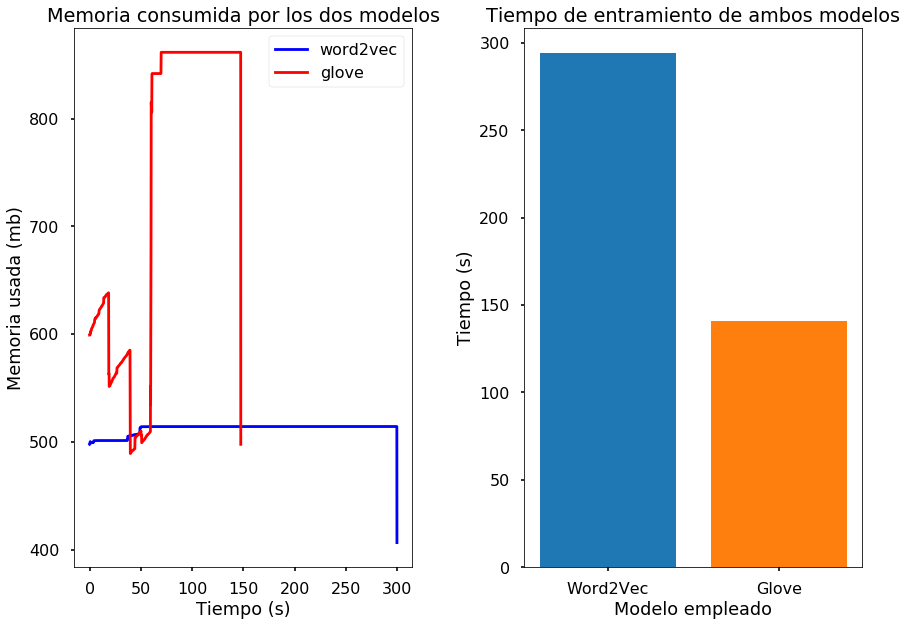

In [39]:
mem_usage_glove = memory_usage((profiler.glove_benchmark, (sentences_generator,), {}))
mem_usage_w2v = memory_usage((profiler.word2vec_benchmark, (sentences_generator,), {}))
time_glove = %timeit -n1 -r1 -o -q profiler.glove_benchmark(sentences_generator)
time_w2v = %timeit -n1 -r1 -o -q profiler.word2vec_benchmark(sentences_generator)
profiler.plot_results(mem_usage_glove, mem_usage_w2v, time_glove, time_w2v)

Como podemos ver, el modelo de GloVe utiliza mucha más memoria que el de Word2Vec. Esto es totalmente lógico ya que tiene que construir la matriz de co-ocurrencia ya descrita anteriormente. Sin embargo, el tiempo de ejecución de Glove es bastante inferior al de Word2Vec, llegando a tardar casi la mitad. Para una colección relativamente pequeña como la nuestra no se aprecia mucho la diferencia, pero si se utilizan colecciones mucho más grandes este puede ser un factor interesante a tener en cuenta a la hora de decantarnos por un modelo u otro.

# Referencias

[1] Explicación del funcionamiento del modelo Word2Vec de Google. https://code.google.com/archive/p/word2vec/

[2] Explicación del funcionamiento del modelo Glove de Stanford. https://nlp.stanford.edu/projects/glove/

[3] GloVe: Global Vectors for word representation. https://www.aclweb.org/anthology/D14-1162

[4] Explicación de como funciona GloVe y como implementar el modelo en Python. http://www.foldl.me/2014/glove-python/

[5] Código fuente del tokenizador de tweets de NLTK. http://www.nltk.org/_modules/nltk/tokenize/casual.html

[6] Documentación del módulo word2vec de gensim utilizado. https://radimrehurek.com/gensim/models/word2vec.html

[7] Repositorio en github de la implementación de Glove utilizada. https://github.com/maciejkula/glove-python
